## Clone the GitHub Repo

In [1]:
!git clone https://github.com/bhargav-borah/CIFAR10ImageClassification

Cloning into 'CIFAR10ImageClassification'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 65 (delta 1), reused 0 (delta 0), pack-reused 57
Receiving objects: 100% (65/65), 978.40 KiB | 18.12 MiB/s, done.
Resolving deltas: 100% (25/25), done.


## Import dependencies

In [2]:
from torchvision.transforms import transforms
import torch
from torch import nn

from pathlib import Path
import os
from CIFAR10ImageClassification.modules.accuracy import accuracy_fn

## Set up device-agnostic code

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Create the train and test dataloaders from CIFAR-10 dataset

In [4]:
from CIFAR10ImageClassification.modules import data_setup

In [5]:
data_dir = 'data'

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.get_cifar10_dataloaders(data_dir=data_dir,
                                                                                    transform=transform,
                                                                                    batch_size=32,
                                                                                    num_workers=os.cpu_count())

100%|██████████| 170498071/170498071 [00:03<00:00, 47333394.97it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Create a model

In [8]:
class CIFAR10ModelV3(nn.Module):
  def __init__(self, input_shape: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=32,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64,
                  out_channels=64,
                  kernel_size=2,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*34*34,
                  out_features=output_shape)
    )

  def forward(self, X: torch.Tensor):
    return self.classifier(self.block_2(self.block_1(X)))

In [9]:
model = CIFAR10ModelV3(input_shape=3,
                       output_shape=len(class_names))
model

CIFAR10ModelV3(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=73984, out_features=10, bias=True)
  )
)

## Time to train our model

In [10]:
os.chdir('CIFAR10ImageClassification/modules')
os.listdir()

['data_setup.py',
 'graphing.py',
 'model_builder.py',
 '__pycache__',
 'accuracy.py',
 'engine.py']

In [11]:
from CIFAR10ImageClassification.modules.model_builder import fit

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)

In [13]:
history = fit(model=model,
              epochs=10,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              device=device,
              accuracy_fn=accuracy_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

Training loss:  1.3998193740844727 | Training accuracy: 0.49956014752388 | Test loss: 1.1554083824157715 | Test accuracy: 0.5928514003753662
Training loss:  1.0594412088394165 | Training accuracy: 0.6312379837036133 | Test loss: 1.061375379562378 | Test accuracy: 0.627595841884613
Training loss:  0.9282293915748596 | Training accuracy: 0.6734644770622253 | Test loss: 0.9650561809539795 | Test accuracy: 0.6593450307846069
Training loss:  0.8250420689582825 | Training accuracy: 0.7128118872642517 | Test loss: 0.9331133365631104 | Test accuracy: 0.6723242402076721
Training loss:  0.7229161858558655 | Training accuracy: 0.748540461063385 | Test loss: 0.9297330379486084 | Test accuracy: 0.6798123121261597
Training loss:  0.6294342279434204 | Training accuracy: 0.7804702520370483 | Test loss: 0.9588040709495544 | Test accuracy: 0.676717221736908
Training loss:  0.5383906364440918 | Training accuracy: 0.8127199411392212 | Test loss: 1.0116297006607056 | Test accuracy: 0.6815095543861389
Train

In [18]:
model.load_state_dict(history['best_state_dict'])

<All keys matched successfully>

## Graph loss and accuracy

In [19]:
from CIFAR10ImageClassification.modules.graphing import plot_loss_curves, plot_accuracy_curves

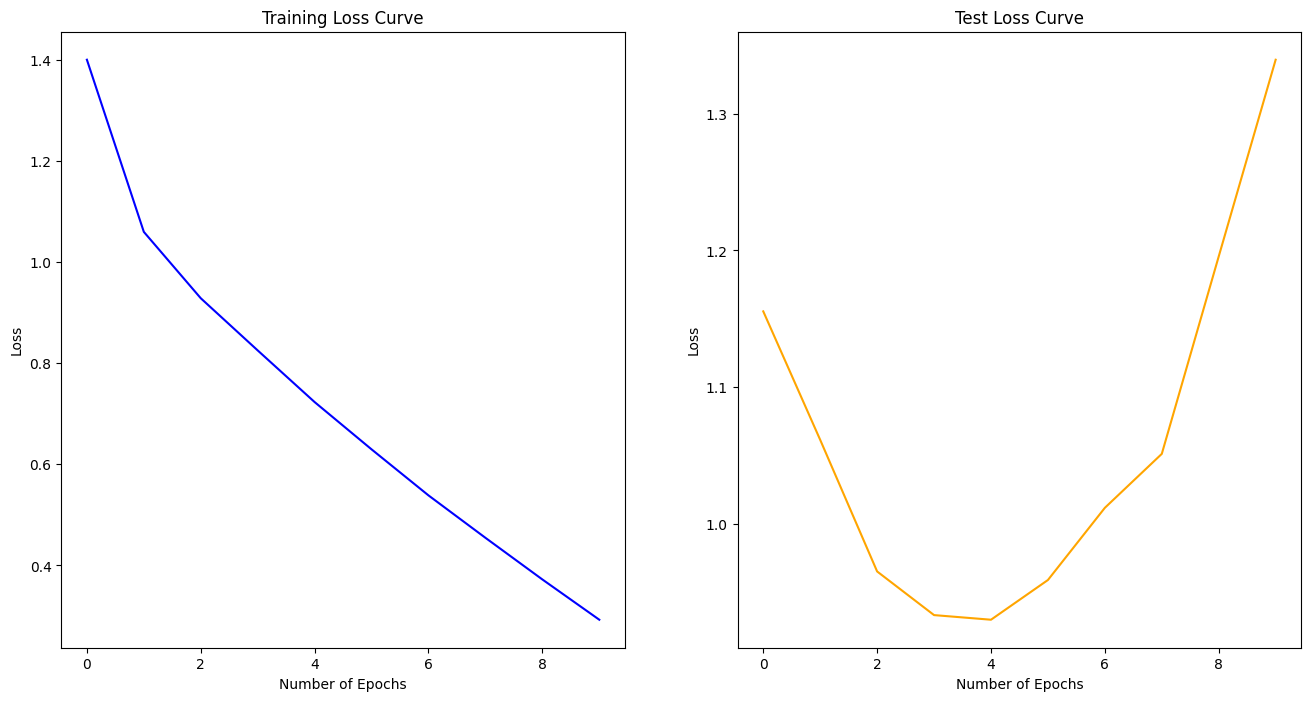

In [20]:
plot_loss_curves(train_losses=history['train_losses'],
                 test_losses=history['test_losses'])

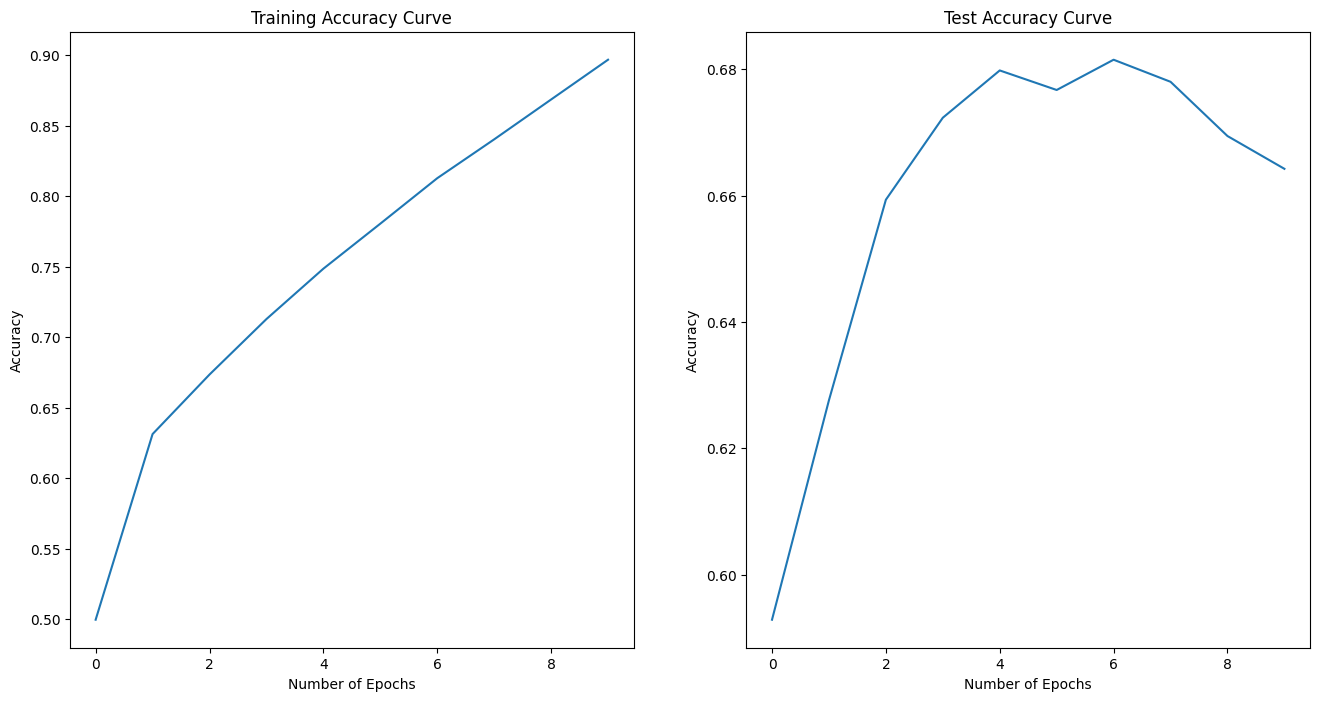

In [21]:
plot_accuracy_curves(train_accuracies=history['train_accuracies'],
                     test_accuracies=history['test_accuracies'])

In [33]:
os.chdir('..')

In [34]:
os.getcwd()

'/content/CIFAR10ImageClassification'

In [35]:
%%writefile modules/eval.py
"""
Contains functionality to evaluate a trained model.
"""
import torch
from accuracy import accuracy_fn

def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device,
               accuracy_fn=accuracy_fn):
  """
  Evaluate the performance of a PyTorch model on a given dataset.

  Args:
  - model (torch.nn.Module): The PyTorch model to evaluate.
  - dataloader (torch.utils.data.DataLoader): DataLoader providing batches of data.
  - loss_fn (torch.nn.Module): The loss function used for evaluation.
  - device (torch.device): The device to perform the evaluation (e.g., 'cuda' or 'cpu').
  - accuracy_fn (function): The function to calculate the accuracy score. Default is 'accuracy_fn'.

  Returns:
  - Tuple[float, float]: A tuple containing the average loss and average accuracy.
  """
  avg_loss, avg_acc = 0, 0

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      avg_loss += loss

      acc = accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(axis=1))
      avg_acc += acc

    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader)

  return avg_loss.item(), avg_acc.item()

Writing modules/eval.py


In [28]:
test_loss, test_acc = eval_model(model=model,
                                 dataloader=test_dataloader,
                                 loss_fn=nn.CrossEntropyLoss(),
                                 device=device)

print(f'Test Loss: {test_loss} | Test Accuracy: {test_acc}')

Test Loss: 1.3395763635635376 | Test Accuracy: 0.6642372012138367


In [29]:
train_loss, train_acc = eval_model(model=model,
                                   dataloader=train_dataloader,
                                   loss_fn=nn.CrossEntropyLoss(),
                                   device=device)

print(f'Train Loss: {train_loss} | Train Accuracy: {train_acc}')

Train Loss: 0.18928289413452148 | Train Accuracy: 0.9377799034118652
